Install `xlrd` for reading the `xls` file

In [38]:
# %conda install xlrd==2.0.1

Set the path to the `xls` file

In [39]:
training_file = "../TrainDataset2024.xls"
# training_file = "/kaggle/input/dataset/TrainDataset2024.xls"

Import libraries

In [40]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('../'))  # Adjust the path as needed

from my_util import df_to_corr_matrix, remove_outliers

from enum import Enum

import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from joblib import Parallel, delayed

from pickle import dump , load

import warnings

### Read the data and load the selected features

In [41]:
NUM_OF_SELECTED_FEATURES = "corr_25"

data = pd.read_excel(training_file)
data.replace(999, np.nan, inplace=True)

data.drop(["ID", "RelapseFreeSurvival (outcome)"], axis=1, inplace=True)
data.dropna(subset=["pCR (outcome)"], inplace=True)

with open(f'../FeatureSelection/pkl/{NUM_OF_SELECTED_FEATURES}_selected_features.pkl', mode='rb') as file:
    selected_features = load(file)
    print(f"Loaded '{file.name}' to selected_feature")

X = data[selected_features]
y = data["pCR (outcome)"]
print(X.shape, y.shape)

print(selected_features)

Loaded '../FeatureSelection/pkl/corr_25_selected_features.pkl' to selected_feature
(395, 25) (395,)
['Gene', 'HER2', 'PgR', 'ER', 'original_firstorder_10Percentile', 'original_ngtdm_Busyness', 'LNStatus', 'TumourStage', 'original_gldm_DependenceEntropy', 'original_firstorder_Skewness', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_ngtdm_Strength', 'original_gldm_SmallDependenceEmphasis', 'original_firstorder_InterquartileRange', 'original_shape_MajorAxisLength', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_firstorder_Minimum', 'HistologyType', 'ChemoGrade', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterColumn', 'original_shape_SurfaceVolumeRatio', 'original_shape_LeastAxisLength', 'original_glcm_Autocorrelation', 'original_shape_Sphericity']


### Split the data into train_full and test_reserved (untouch)

In [42]:
# Close ratio random_state
# [14, 47, 49, 52, 62, 76, 83, 89, 92, 116, 118, 122, 136, 138, 144, 146, 150, 156, 157, 159, 170, 172, 174, 185]

while True:  
    X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X, y, test_size=0.2, random_state=14) # similar distribution of 1 and 0
    # X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X, y, test_size=0.2, random_state=None)

    X_train_full.reset_index(drop=True, inplace=True)
    X_test_reserved.reset_index(drop=True, inplace=True)
    y_train_full.reset_index(drop=True, inplace=True)
    y_test_reserved.reset_index(drop=True, inplace=True)

    ratio_train = sum(y_train_full[y_train_full==1]) / len(y_train_full)
    ratio_test = sum(y_test_reserved[y_test_reserved==1]) / len(y_test_reserved)

    if abs(ratio_train - ratio_test) < 0.1:
        break

print("Splited the data into train and test. The test will not be used in the training, but just for test the model. ")
print(f"The training data has {len(X_train_full)} data. The testing data has {len(X_test_reserved)} data. ")
print(f"Positive ratio: \n\tTrain: {ratio_train:.5f}\n\tTest: {ratio_test:.5f}")

Splited the data into train and test. The test will not be used in the training, but just for test the model. 
The training data has 316 data. The testing data has 79 data. 
Positive ratio: 
	Train: 0.21203
	Test: 0.21519


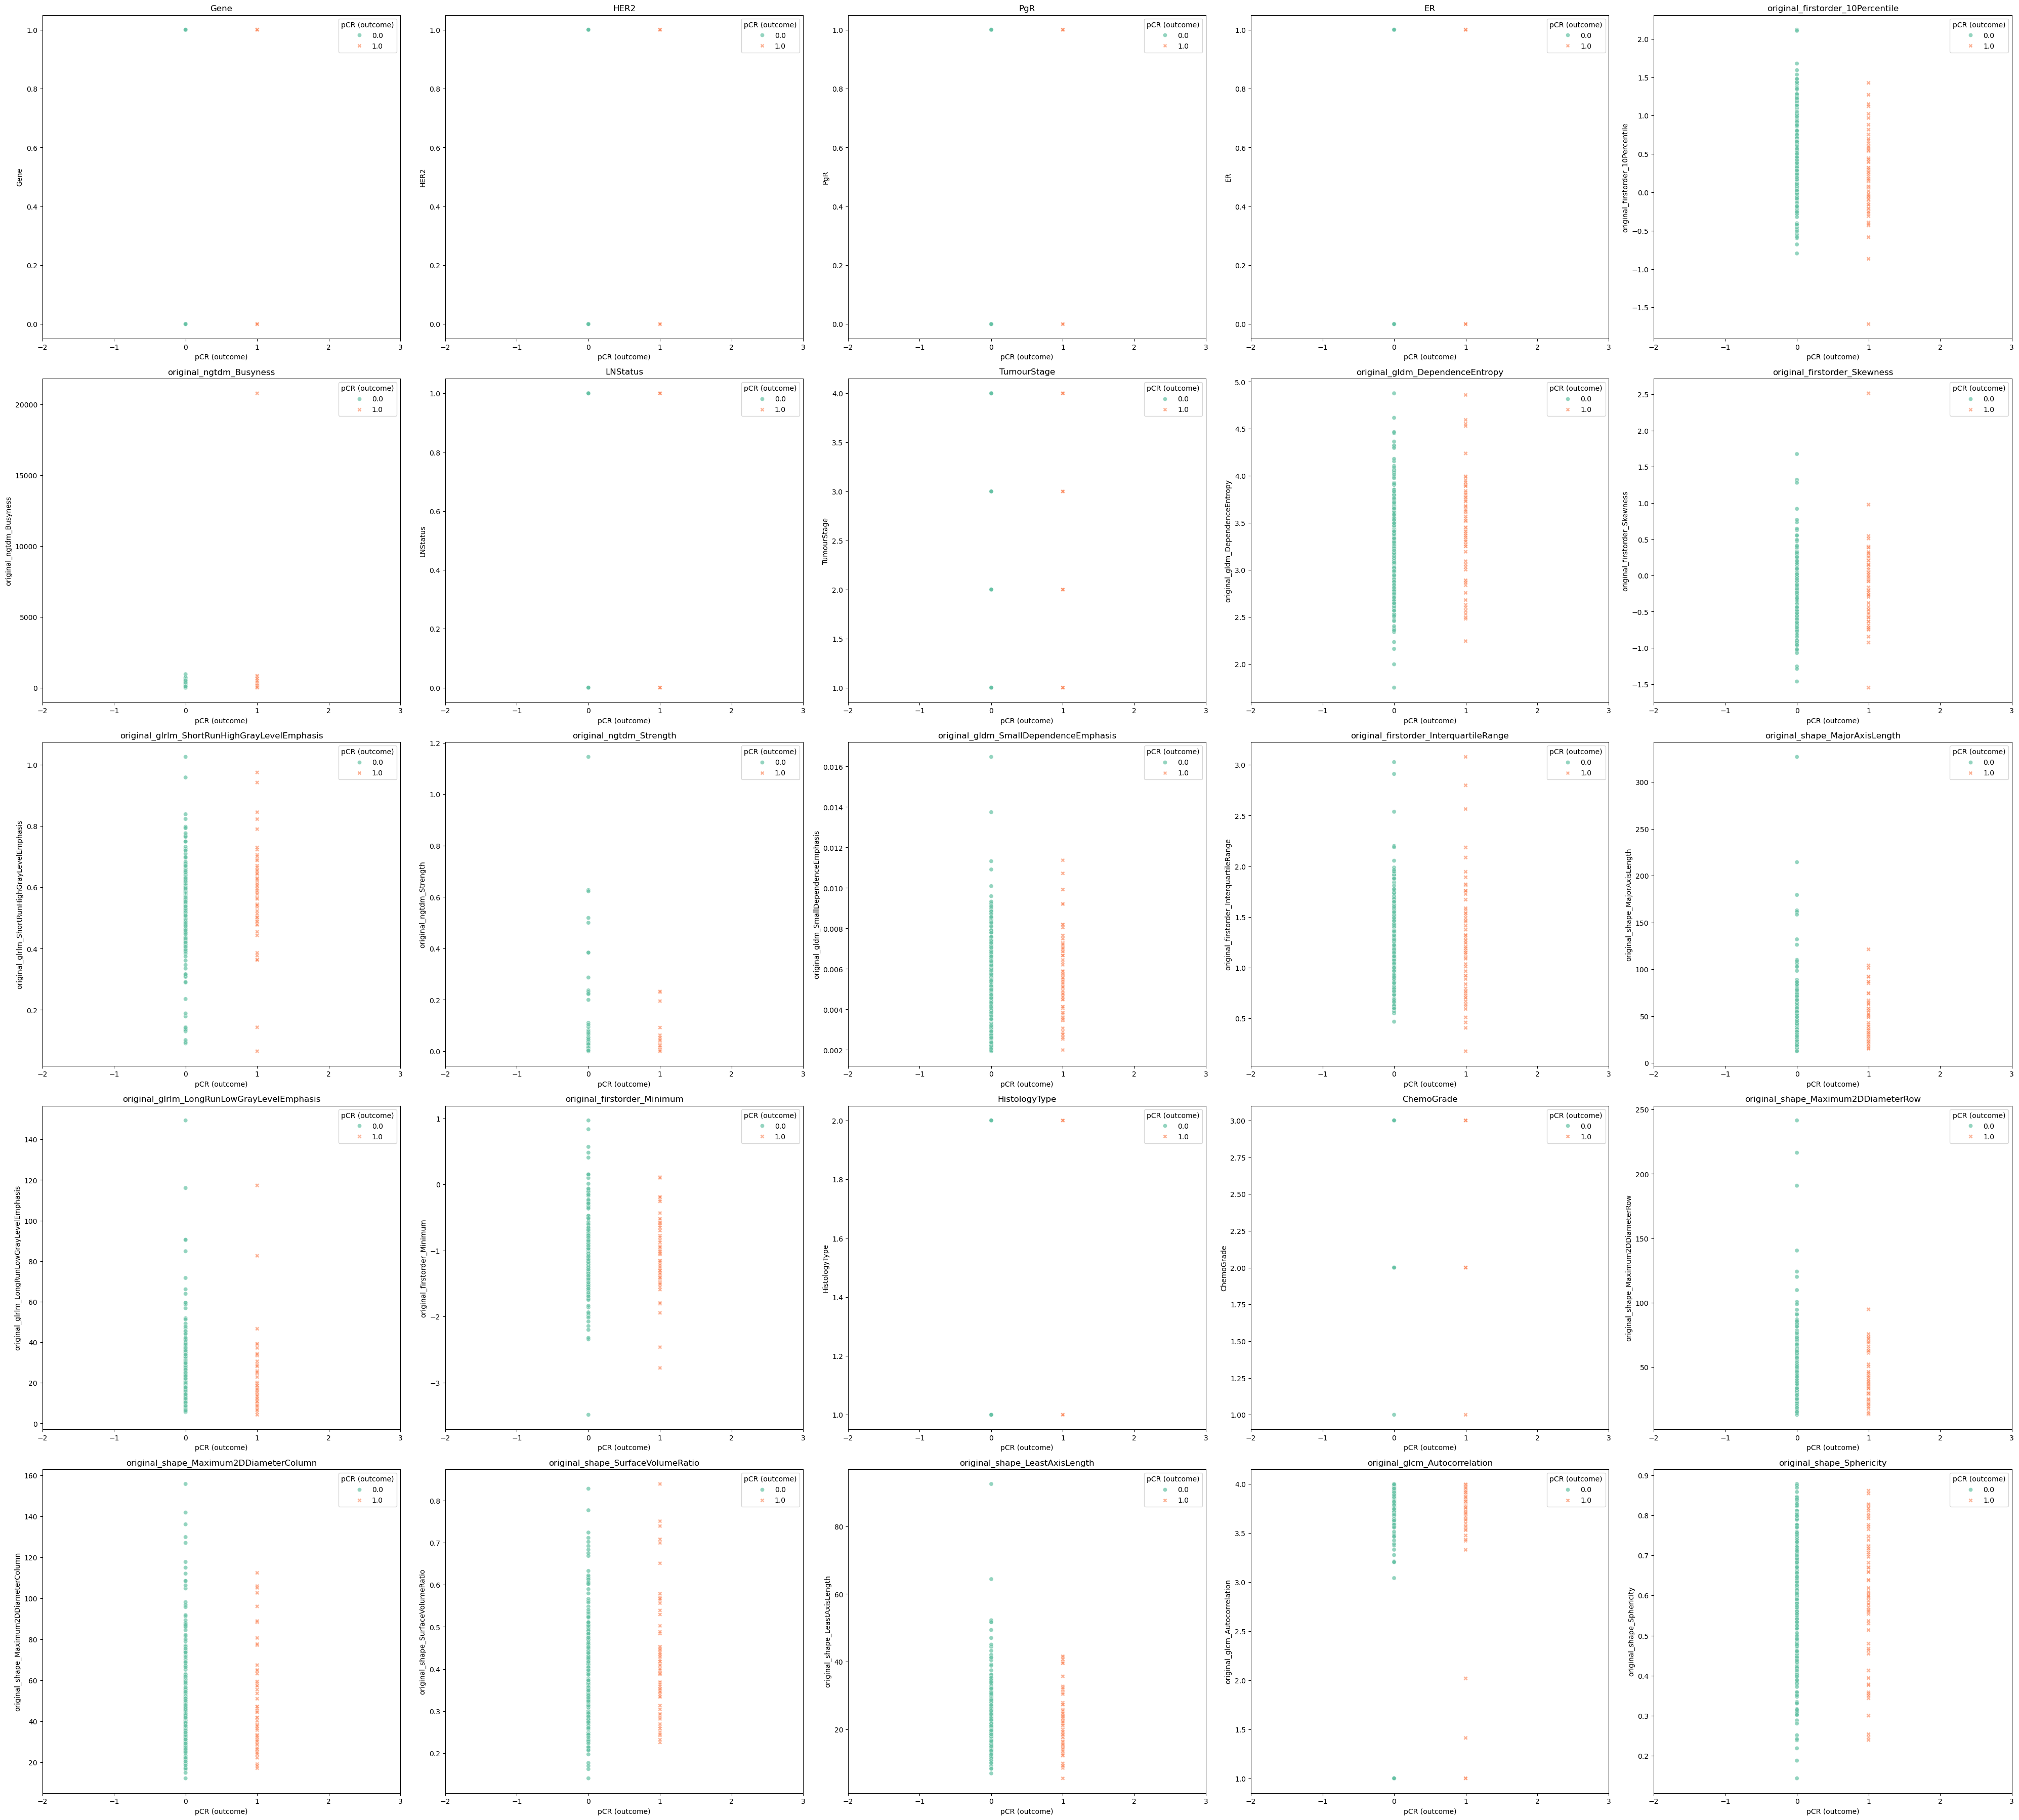

In [43]:
def show_scatter_plots():
    # Set up the matplotlib figure
    plt.figure(figsize=(40, 50))

    # Loop through each feature to create a scatter plot
    for i, feature in enumerate(X_train_full.columns):
        plt.subplot(7, 5, i + 1)  # Adjust the number of rows and columns based on the number of features
        sns.scatterplot(x=y_train_full, y=X_train_full[feature], hue=y_train_full, style=y_train_full, palette='Set2', alpha=0.7)
        plt.title(feature)
        plt.xlabel('pCR (outcome)')
        plt.ylabel(feature)
        plt.xlim(-2, 3)

    plt.tight_layout()
    plt.show()
show_scatter_plots()

### Remove outliers

In [44]:
# feature = "original_glcm_Correlation"

# for i in range(7):
#   print(list(X.columns[i*5:(i+1)*5]))
# df = {}
# df[0] = data[data["pCR (outcome)"] == 0]
# df[1] = data[data["pCR (outcome)"] == 1]

# nth_largest = lambda n, df, feature : (df[feature].nlargest(n))
# nth_smallest = lambda n, df, feature : (df[feature].nsmallest(n))

# n = 15
# largest0 = (nth_largest(n, df[0], feature)).reset_index(drop=True)
# largest1 = (nth_largest(n, df[1], feature)).reset_index(drop=True)
# smallest0 = (nth_smallest(n, df[0], feature)).reset_index(drop=True)
# smallest1 = (nth_smallest(n, df[1], feature)).reset_index(drop=True)
# temp = pd.concat([largest0, smallest0, largest1, smallest1], axis=1)
# temp.columns=["largest0", "smallest0", "largest1", "smallest1"]
# display(temp)
# sns.scatterplot(x=y, y=X[feature], hue=y, style=y, palette='Set2', alpha=0.7)

In [45]:
# class ReplaceMethod(Enum):
#     SMALLEST = 0
#     LARGEST = 1

# replace_list = [
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_firstorder_10Percentile", "outcome": 0, "threshold": 1.678166},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_firstorder_10Percentile", "outcome": 1, "threshold": -0.617352},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_ngtdm_Busyness", "outcome": 1, "threshold": 838.677442},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_gldm_DependenceEntropy", "outcome": 1, "threshold": 2.478963},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_firstorder_Skewness", "outcome": 1, "threshold": 0.545105},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_firstorder_Skewness", "outcome": 0, "threshold": 0.767485},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_firstorder_Skewness", "outcome": 1, "threshold": -0.995207},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_glrlm_ShortRunHighGrayLevelEmphasis", "outcome": 1, "threshold": 0.363247},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_glrlm_ShortRunHighGrayLevelEmphasis", "outcome": 0, "threshold": 0.838612},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_gldm_SmallDependenceEmphasis", "outcome": 0, "threshold": 0.011321},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_shape_MajorAxisLength", "outcome": 0, "threshold": 162.863366},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_glrlm_LongRunLowGrayLevelEmphasis", "outcome": 1, "threshold": 39.241005},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_glrlm_LongRunLowGrayLevelEmphasis", "outcome": 0, "threshold": 90.572934},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_firstorder_Minimum", "outcome": 0, "threshold": -2.346176},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_firstorder_Minimum", "outcome": 1, "threshold": -2.052288},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_shape_Maximum2DDiameterRow", "outcome": 1, "threshold": 77.252832},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_shape_Maximum2DDiameterRow", "outcome": 0, "threshold": 124.193398},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_shape_SurfaceVolumeRatio", "outcome": 0, "threshold": 0.723904},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_shape_SurfaceVolumeRatio", "outcome": 1, "threshold": 0.772898},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_shape_SurfaceVolumeRatio", "outcome": 1, "threshold": 0.215198},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_shape_LeastAxisLength", "outcome": 0, "threshold": 52.226330},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_shape_LeastAxisLength", "outcome": 1, "threshold": 41.589009},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_shape_LeastAxisLength", "outcome": 1, "threshold": 8.531971},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_glcm_Autocorrelation", "outcome": 0, "threshold": 3.040814},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_glcm_Autocorrelation", "outcome": 1, "threshold": 3.297653},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_glszm_SizeZoneNonUniformityNormalized", "outcome": 0, "threshold": 0.653333},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_glszm_SizeZoneNonUniformityNormalized", "outcome": 1, "threshold": 0.500000},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_glszm_SmallAreaEmphasis", "outcome": 1, "threshold": 0.643301},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_shape_Elongation", "outcome": 0, "threshold": 0.299156},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_shape_Elongation", "outcome": 1, "threshold": 0.350000},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_firstorder_Kurtosis", "outcome": 1, "threshold": 4.760064},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_firstorder_Kurtosis", "outcome": 0, "threshold": 5.157534},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_glszm_GrayLevelNonUniformity", "outcome": 1, "threshold": 204.009709},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_glszm_GrayLevelNonUniformity", "outcome": 0, "threshold": 290.006849},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_glcm_Imc1", "outcome": 1, "threshold": -0.399542},
#     {"replace_method": ReplaceMethod.SMALLEST, "feature": "original_glcm_Imc1", "outcome": 0, "threshold": -0.451831},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_firstorder_90Percentile", "outcome": 0, "threshold": 4.883197},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_firstorder_90Percentile", "outcome": 1, "threshold": 4.087205},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_glcm_Correlation", "outcome": 1, "threshold": 0.569794},
#     {"replace_method": ReplaceMethod.LARGEST, "feature": "original_glcm_Correlation", "outcome": 0, "threshold": 0.704593},
# ]

# for task in replace_list:
#     outcome = task["outcome"]
#     feature = task["feature"]
#     threshold = task["threshold"]
#     num_of_replace = 0
#     if feature not in X.columns:
#         continue
#     if task["replace_method"] == ReplaceMethod.LARGEST:
#         num_of_replace = len(data.loc[(data["pCR (outcome)"] == outcome) & (data[feature] > threshold), feature])
#         data.loc[(data["pCR (outcome)"] == outcome) & (data[feature] > threshold), feature] = threshold
#     elif task["replace_method"] == ReplaceMethod.SMALLEST:
#         num_of_replace = len(data.loc[(data["pCR (outcome)"] == outcome) & (data[feature] < threshold), feature])
#         data.loc[(data["pCR (outcome)"] == outcome) & (data[feature] < threshold), feature] = threshold
#     print(f"Replaced {num_of_replace} records in {feature}[{outcome}] to {threshold}")

# X = data[selected_features]
# y = data["pCR (outcome)"]

In [56]:
X_train_full, y_train_full = remove_outliers(X_train_full, y_train_full, selected_features)

Replaced 3 records in original_firstorder_10Percentile[0] to 1.678166
Replaced 2 records in original_firstorder_10Percentile[1] to -0.617352
Replaced 2 records in original_ngtdm_Busyness[1] to 838.677442
Replaced 1 records in original_gldm_DependenceEntropy[1] to 2.478963
Replaced 2 records in original_firstorder_Skewness[1] to 0.545105
Replaced 5 records in original_firstorder_Skewness[0] to 0.767485
Replaced 1 records in original_firstorder_Skewness[1] to -0.995207
Replaced 2 records in original_glrlm_ShortRunHighGrayLevelEmphasis[1] to 0.363247
Replaced 2 records in original_glrlm_ShortRunHighGrayLevelEmphasis[0] to 0.838612
Replaced 2 records in original_gldm_SmallDependenceEmphasis[0] to 0.011321
Replaced 4 records in original_shape_MajorAxisLength[0] to 162.863366
Replaced 3 records in original_glrlm_LongRunLowGrayLevelEmphasis[1] to 39.241005
Replaced 2 records in original_glrlm_LongRunLowGrayLevelEmphasis[0] to 90.572934
Replaced 2 records in original_firstorder_Minimum[0] to -

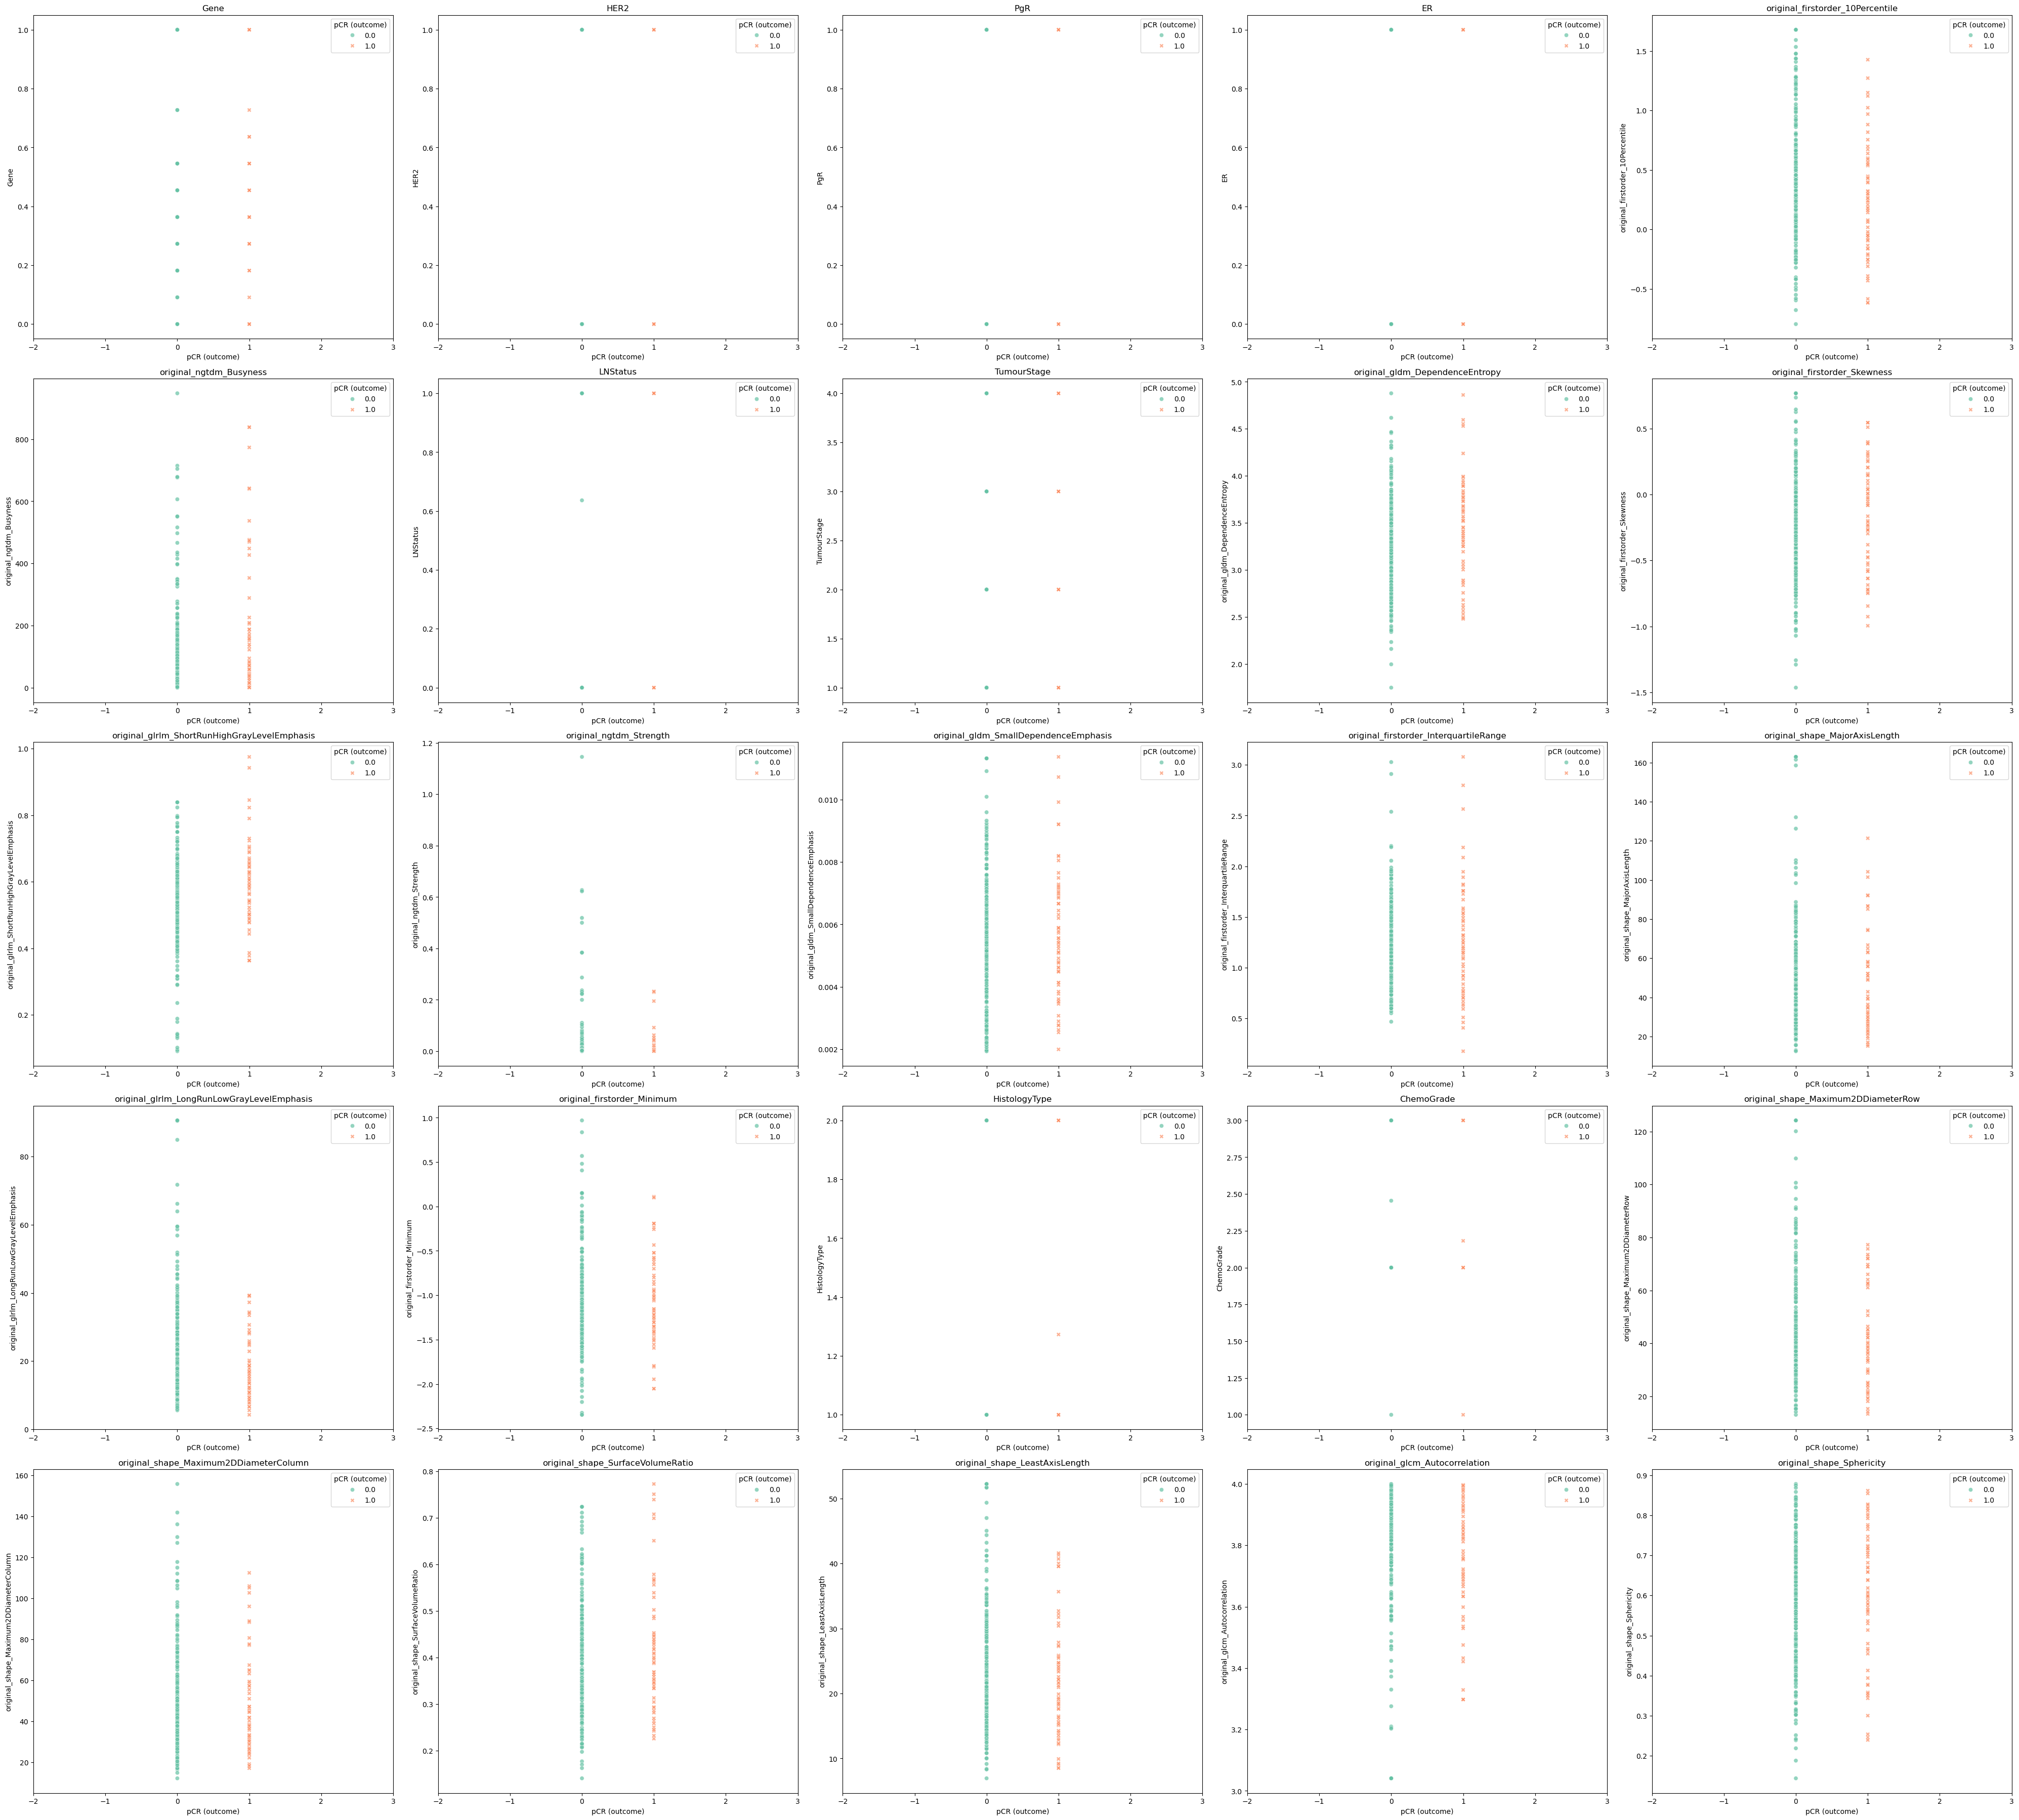

In [57]:
show_scatter_plots()

### KNNImputer

In [58]:
n_neighbors = 11

imputer = KNNImputer(n_neighbors=n_neighbors)
X_train_full = pd.DataFrame(imputer.fit_transform(X_train_full), columns=X_train_full.columns)
print("Imputed training data with KNNImputer. Read the data into X_train_full and y_train_full.")
print(X_train_full.shape, y_train_full.shape)

with open("pkl/imputer.pkl", 'wb') as file:
    dump(imputer, file)
    print(f"Saved imputer to '{file.name}'")

Imputed training data with KNNImputer. Read the data into X_train_full and y_train_full.
(316, 25) (316,)
Saved imputer to 'pkl/imputer.pkl'


### Normalisation

##### Standardisation

In [59]:
scaler = StandardScaler()
Xs_standardisation = scaler.fit_transform(X_train_full)
Xs_standardisation = pd.DataFrame(Xs_standardisation, columns=X_train_full.columns)

with open("pkl/StandardScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/StandardScaler.pkl'")

Saved scaler to 'pkl/StandardScaler.pkl'


##### Robust Scaler

In [60]:
scaler = RobustScaler()
Xs_robustScaler = scaler.fit_transform(X_train_full)
Xs_robustScaler = pd.DataFrame(Xs_robustScaler, columns=X_train_full.columns)

with open("pkl/RobustScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/RobustScaler.pkl'")

Saved scaler to 'pkl/RobustScaler.pkl'


In [61]:
SCALER = "standard"

In [62]:
# SCALER = "robust"

In [63]:
if SCALER == "standard":
    Xs = Xs_standardisation
else:
    Xs = Xs_robustScaler

(25, 25)


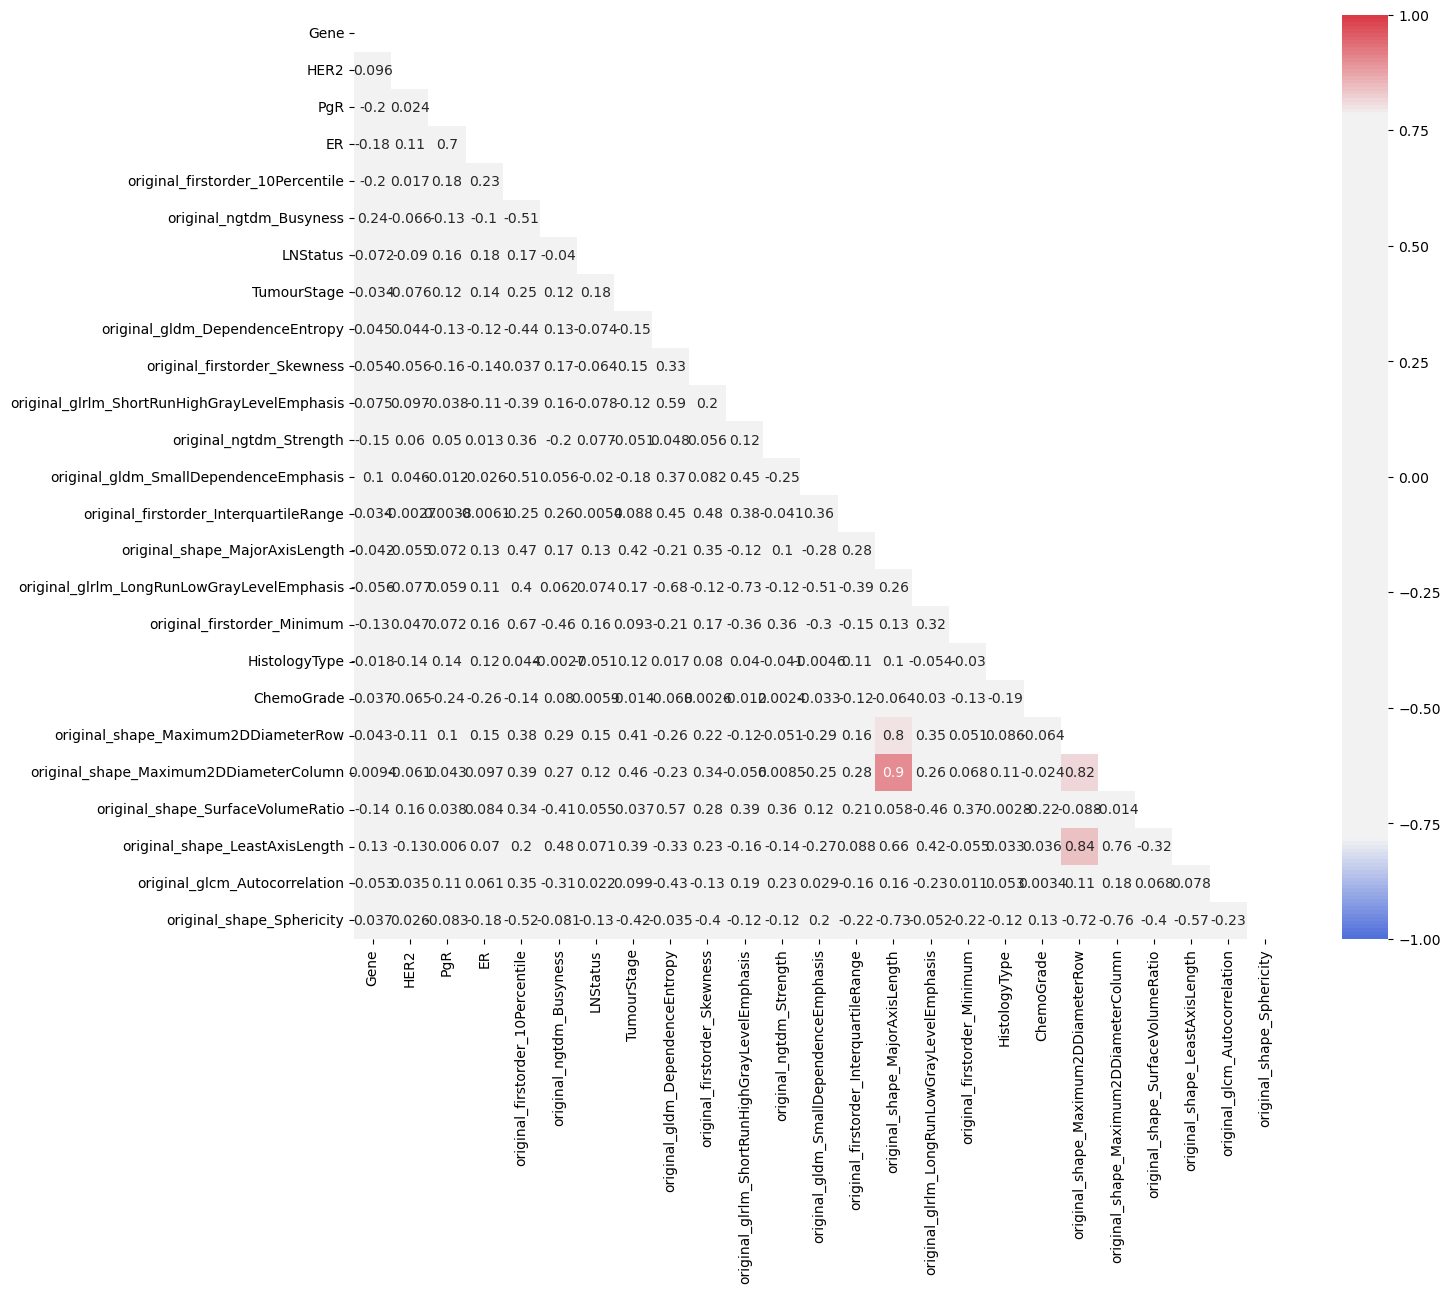

In [64]:
df_to_corr_matrix(Xs, size_factor=1.5)

### IMB Pipeline

In [66]:
pipeline = Pipeline([
  ('pca', PCA()),
  ('sampling', SMOTE()),
  ('tree', DecisionTreeClassifier()),
])

param_grid = {
    'pca__n_components': [9, 11, 13, 14, 15],
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__splitter': ['best', 'random'],
    'tree__max_depth': [2, 3, 4, 5, 6],
    'tree__min_samples_split': [2, 5, 10, 15, 30],
    'tree__min_samples_leaf': [2, 4, 6, 8, 10]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
      "f1": "f1", 
      "recall": "recall", 
      'specificity': make_scorer(recall_score,pos_label=0),
      'precision': 'precision',
      },
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
    refit="f1",
)
# Fit the model
grid_search.fit(Xs, y_train_full)

# Get the best parameters and best score
result = pd.DataFrame(grid_search.cv_results_)
best_params = grid_search.best_params_
best_index = grid_search.best_index_
best_f1 = result["mean_test_f1"][best_index]
best_precision = result["mean_test_precision"][best_index]
best_recall = result["mean_test_recall"][best_index]
best_specificity = result["mean_test_specificity"][best_index]

print(f"Best Parameters at Index {best_index} :", best_params)
print(f"F1 Score: {best_f1}")
print(f"Precision Score: {best_precision}")
print(f"Recall Score: {best_recall}")
print(f"Specificity Score: {best_specificity}")

pd.DataFrame(grid_search.cv_results_).to_csv("output.csv")

Fitting 5 folds for each of 3750 candidates, totalling 18750 fits


/home/ubuntu/miniconda3/envs/MLEAsm/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters at Index 2369 : {'pca__n_components': 14, 'tree__criterion': 'gini', 'tree__max_depth': 4, 'tree__min_samples_leaf': 4, 'tree__min_samples_split': 30, 'tree__splitter': 'random'}
F1 Score: 0.508998557702777
Precision Score: 0.39233197961458827
Recall Score: 0.7593406593406594
Specificity Score: 0.6709387755102041


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
print(list(results.keys())[4:10])

['param_pca__n_components', 'param_tree__criterion', 'param_tree__max_depth', 'param_tree__min_samples_leaf', 'param_tree__min_samples_split', 'param_tree__splitter']


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)

filter = results['mean_train_recall'] == 1
filter = pd.Series([True] * len(results)) # include all data

fig = go.Figure()
# Add mean train score trace
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_train_f1"][filter]))),
    y=results["mean_train_f1"][filter],
    mode='lines+markers',
    name='Mean Train F1',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_train_recall"][filter]))),
    y=results["mean_train_recall"][filter],
    mode='lines+markers',
    name='Mean Train Recall',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))
# Add mean test score trace
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_test_f1"][filter]))),
    y=results["mean_test_f1"][filter],
    mode='lines+markers',
    name='Mean Test F1',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_test_recall"][filter]))),
    y=results["mean_test_recall"][filter],
    mode='lines+markers',
    name='Mean Test Recall',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))

# Update layout
fig.update_layout(
    title='Grid Search Mean Train and Test Scores',
    xaxis_title='Parameter Combinations (Index)',
    yaxis_title='Score',
    legend_title='Scores',
    hovermode='closest'
)
fig.show()

In [ ]:
with open("pkl/StandardScaler.pkl", "rb") as file:
  scaler = load(file)

with open("pkl/imputer.pkl", "rb") as file:
  imputer = load(file)

model = grid_search.best_estimator_

# print(f"TARGET_NUM_OF_FEATURES: {TARGET_NUM_OF_FEATURES}, scaler: {SCALER}, num_of_features: {num_of_features}")

print(f"Best Parameters at Index {best_index} :", best_params)
print("Best Cross-Validation Score:", best_score)

y_pred = model.predict(Xs)
report = classification_report(y_train_full, y_pred)
cm = confusion_matrix(y_train_full, y_pred)

print("\nTraining set:")
print(report)
print(cm)

X_test = imputer.transform(X_test_reserved)
X_test = pd.DataFrame(X_test, columns=X_test_reserved.columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_test_reserved.columns)

y_pred = model.predict(X_test)
report = classification_report(y_test_reserved, y_pred)
cm = confusion_matrix(y_test_reserved, y_pred)

print("Untouched testing set:")
print(report)
print(cm)



Best Parameters at Index 2993 : {'pca__n_components': 14, 'tree__criterion': 'log_loss', 'tree__max_depth': 6, 'tree__min_samples_leaf': 10, 'tree__min_samples_split': 5, 'tree__splitter': 'random'}
Best Cross-Validation Score: 0.5091406850988733

Training set:
              precision    recall  f1-score   support

         0.0       0.89      0.78      0.83       249
         1.0       0.44      0.64      0.52        67

    accuracy                           0.75       316
   macro avg       0.66      0.71      0.68       316
weighted avg       0.79      0.75      0.77       316

[[194  55]
 [ 24  43]]
Untouched testing set:
              precision    recall  f1-score   support

         0.0       0.81      0.68      0.74        62
         1.0       0.26      0.41      0.32        17

    accuracy                           0.62        79
   macro avg       0.53      0.54      0.53        79
weighted avg       0.69      0.62      0.65        79

[[42 20]
 [10  7]]
